# Predicting muscle activity from M1 neural recordings and latent signals

## Background

In this session you will be working with some monkey data. You will have the opportunity to explore the relationship between the activity of neurons in motor cortex (M1) and the activity of quite a few forearm and hand muscles. 

All data were collected in Miller Limb Lab, Northwestern University. Jango, is the name of the monkey. He was trained to sit in a primate chair and perform a motor task. The task required him to place his left hand inside a small box and control a cursor on a screen by exerting forces within the box. Details about the task are shown in the figure below.

![Experiment paradigm](../images/exp_background.png)

We implanted a 96-channel Utah electrode array (Blackrock Neurotech, Inc.) in the hand representation of the primary motor cortex (M1) contralateral to the arm being used for the task. We also implanted intramuscular leads in forearm and hand muscles of the arm used for the task.

M1 neural activity was recorded using a Cerebus system (Blackrock Neurotech, Inc.) during task performance. The signals on each channel were digitalized, bandpass filtered (250 ~ 5000 Hz) and converted to spike times based on threshold crossings. The threshold was set with respect to the root-mean square (RMS) activity on each channel (-5.5 x RMS). Here we will use multiunit threshold crossings on each channel instead of well isolated single units for all analyses. 

![Data collection](../images/exp_implant.png)

The EMG signals were differentially amplified, band-pass filtered (4-pole, 50 ~ 500 Hz) and sampled at 2000 Hz. The EMGs were subsequently digitally rectified and low-pass filtered (4-pole, 10 Hz, Butterworth) to get the envelopes, which preserve the information about the activation timing and level for the muscles, but throw the high frequency components away.

![EMG preprocessing](../images/EMG_preprocessing.png)

## Load the data

First up, we'll load the data. Both M1 and EMG data as well as behavioral information were saved in a Python dictionary and stored by `pickle`.

In [137]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

with open('../data/jango.monkey', 'rb') as fp:
    jango = pickle.load(fp)

We can print the field names in the dictionary to have an overview of the data. 

In [15]:
print(jango.keys())

dict_keys(['M1 firing rates', 'EMG', 'target direction', 'target corners', 'force', 'cursor position', 'cursor velocity', 'muscle name', 'M1 elec name', 'spike timing'])


These field names are quite self-explanatory, they are basically what you think they should be. Specifically, `jango['spike timing']` contains the very raw spiking activity recorded from each electrode. `jango['spike timing']` is a list with 583 elements, corresponding to 583 trials in the dataset. Each element in `jango['spike timing']` is also a list, and contains 96 elements, for the 96 electrodes. Use the command below you can print the time ticks (in second) of the spikes at the 47th electrode during the 52nd trial.

In [16]:
print('The time ticks (in second) of the spikes at the 47th electrode during the 52nd trial:')
print(jango['spike timing'][52][47])

The time ticks (in second) of the spikes at the 47th electrode during the 52nd trial:
[0.08983333 0.1499     0.1991     0.22406667 0.283      0.29893333
 0.35573333 0.424      0.43343333 0.51523333 0.53356667 0.56093333
 0.59696667 0.68306667 0.6967     0.77126667 0.85593333 1.1868
 1.23476667 1.4335     1.4921     1.49526667 1.5329     1.5449
 1.60533333 1.65726667 1.80373333 1.83413333 1.87406667 1.95133333]


Generally, we will not directly working with the raw spike timings. We will need to convert the spike timings into firing rates first for each electrode. Here this preprocessing has already been done. We counted the number of spikes in consecutive 25 ms non-overlapping windows, and applied a Gaussian kernel (S.D. = 50 ms) to smooth the obtained spike counts. These processed data are saved in `jango['M1 firing rates']`. Similarly, there are in total 583 elements in this list, corresponding to the 583 trials. Each element in `jango['M1 firing rates']` is an array with a shape:

In [4]:
print('The length of M1 firing rates is %d'%(len(jango['M1 firing rates'])))
print('The shape of jango[\'M1 firing rates\'][i] is ' + str(jango['M1 firing rates'][0].shape))

The length of M1 firing rates is 583
The shape of jango['M1 firing rates'][i] is (80, 96)


The rows are for samples and the columns for channels (electrodes). For convinience, we've already time-aligned each trial to the onset of forces, and only took the portion from 0.5 s before the force onset to 1.5 s after the force onset. Obviously, there would be 2/0.025 = 80 temporal samples for each trial

`jango['EMG']` contains the EMG envelops for each muscle. Similarly, it has 583 elements. The EMG recordings are strictly syncronized with the M1 recordings. The number of recorded mucles and the names for them are shown below:

In [5]:
print('There are %d muscles being recorded, and their names are:'%(jango['EMG'][0].shape[1]))
print(jango['muscle name'])

There are 11 muscles being recorded, and their names are:
['EMG_FCRr', 'EMG_FCUu', 'EMG_FDPr', 'EMG_FDPu', 'EMG_FDSu', 'EMG_PL', 'EMG_PT', 'EMG_FDS', 'EMG_ECU', 'EMG_ECRb', 'EMG_EDC1']


The full names of the muscles could be easily found online, but here you may only need a rough grouping for them.

* FCR, FCU, ECU, ECR are the 4 wrist muscles mentioned above, they are directly related to the task.
* FDP, FDS and EDC are also in the forearm, majorly for the performing hand grasping, but also have activity during the wrist task.
* PT is for the pronation of forearm.

`jango['target direction']` contains the target direction for each trial. 

In [6]:
print('In the 69th trial the monkey moved toward the target at %d degrees'%(jango['target direction'][69]))

In the 69th trial the monkey moved toward the target at 180 degrees


Targets were evenly distributed through the whole experimental session. To select the trials for specific targets, you may want to build a function to sort the trials into a list of lists. There are some useful coding techniques when doing this:
* Use `np.where()[0]` to find the indices for the trials toward a specific target.
* `[list1[i] for i in idx]` to select items according to the indices and put them in a new list. 
* `sum(list, [])` to concatenate the elements in a list of lists, and obtain a new list
* `np.concatenate(list)` to concatenate the elements in a list, and obtain an ndarray.

<span style="color:red">**TO DO** </span>

* Write a function to select the trials toward specific targets (given by a list), and save the results as a list of lists.

In [115]:
jango_target_direction = np.array(jango['target direction'])

def select_trials(dataset, field_name, target_directions):
    """
    To select the trials toward specific targets and save them as a list of lists
    Input
        dataset: the name of the data dictionary, like 'jango'
        field_name: the name of the data field you want to extract data from, could be 'M1 firing rates', 'EMG', etc.
        target_directions, a list containing the target directions you want to extract, like [-90, 90, 135]
    Return
        A list of lists, each element contains those trials for the corresponding target in target_directions
    Sample call
        To get the M1 firing rates for trials of diagonal targets, just call
            M1_firing_rates = select_trials(jango, 'M1 firing rates', [45, 135, -45, -135])
        To get the EMGs for trials of diagonal targets, just call
            EMG = selec_trials(jango, 'EMG', [45, 135, -45, -135])
    """
    # ---- Your codes ---- #

    trial_data = []
    for each in target_directions:
        idx = np.where(np.array(dataset['target direction']) == each)[0]
        trial_data.append([dataset[field_name][i] for i in idx])
    return trial_data

In [116]:
len(select_trials(jango, 'EMG', [180,90]))

2

## Visualize the high-dimensional data

Here you are provided a function to visualize M1 neural activity and selected EMGs in individual trials.

In [48]:
def plot_spike_EMG(dataset, trial_num, EMG_names, offset, bin_size, FR_flag):
    """
    To plot the neural signals and the selected EMGs during a specific trial in two different forms (rasters, pcolormesh) 
    Input
        dataset: the name of the data dictionary, like 'jango'
        trial_num: an int number specifying the number of the trial you want to plot
        EMG_names: a list of strings, specifying the EMGs of the muscles you are interested in
        offset: the offset to adjust the time axis
        bin_size: the size of bin for spike counting
        FR_flag: a flag indicating whether you want to plot firing rates with pcolormesh or plot rasters for the raw spike timing
    Return
        No return, but will produce a figure
    """
    spikes = dataset['spike timing'][trial_num]
    EMG = dataset['EMG'][trial_num]
    EMG_chs = [dataset['muscle name'].index(each) for each in EMG_names]
    N = len(EMG_chs)
    spike_grid = 5
    grid = plt.GridSpec(N + spike_grid, 1, wspace=0.5, hspace=0.2)
    main_ax = plt.subplot(grid[0:spike_grid,0])
    plt.title('Target at %d degrees'%(dataset['target direction'][trial_num]), fontsize = 20)
    if FR_flag == 0:
        for i, spiketrain in enumerate(spikes):
            main_ax.plot(spiketrain + offset, np.ones_like(spiketrain) * i, ls='', marker='|', color = 'k', ms = 1)
    else:
        p = dataset['M1 firing rates'][trial_num]
        x=np.arange(p.shape[0])*bin_size + offset
        y=np.arange(p.shape[1])
        cmap=plt.cm.plasma
        im = main_ax.pcolormesh(x, y, p.T/bin_size, cmap=cmap)
    main_ax.axis('off')
    plt.xticks(color = 'w')
    plt.yticks([])
    x = np.arange(EMG.shape[0])*bin_size + offset
    ymin, ymax = np.min([EMG[:, EMG_chs[i]] for i in range(N)]), np.max([EMG[:, EMG_chs[i]] for i in range(N)])
    
    for i in range(N):
        ax0 = plt.subplot(grid[i+spike_grid,0], sharex = main_ax)
        p1 = EMG[:, EMG_chs[i]]
        frame = plt.gca()
        frame.axes.get_yaxis().set_visible(False)
        ax0.spines['top'].set_visible(False)
        ax0.spines['right'].set_visible(False)
        ax0.spines['left'].set_visible(False)
        if i<N-1:
            plt.plot(x, p1, 'k')
            ax0.spines['bottom'].set_visible(False)
            plt.setp(ax0.get_xticklabels(),visible=False)
            ax0.tick_params(axis=u'both', which=u'both',length=0)
        if i == N-1:
            plt.plot(x, p1, 'k')
            ax0.set_xlabel('Time (s)', fontsize = 20)
            plt.tick_params(labelsize = 16)
        plt.ylim(ymin, ymax)
        plt.text(-1, np.max(p1)/2, EMG_names[i][4:], fontsize = 16)

First, let's plot the raw spikes with the EMGs within a single trial for each target.

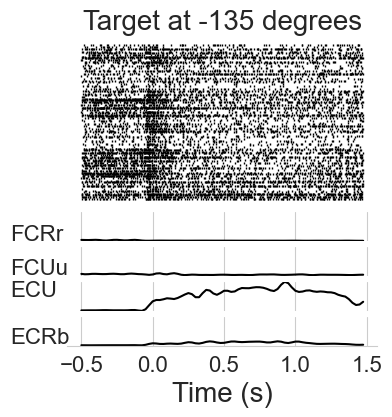

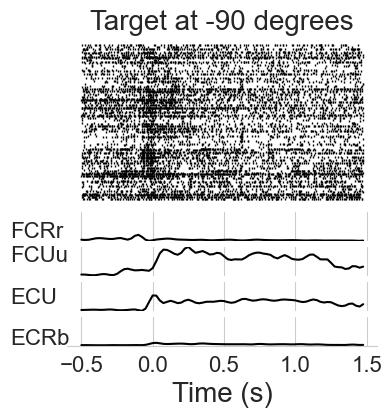

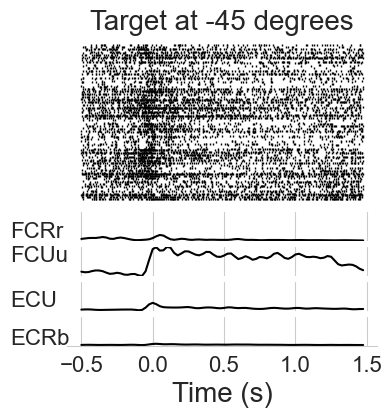

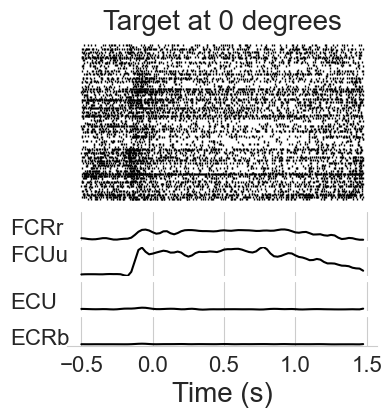

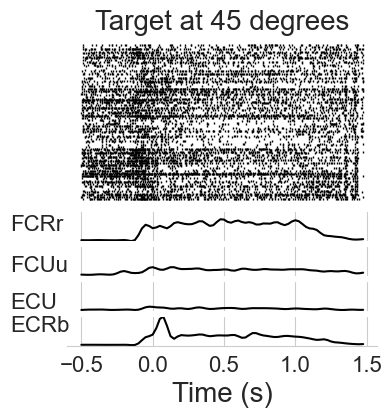

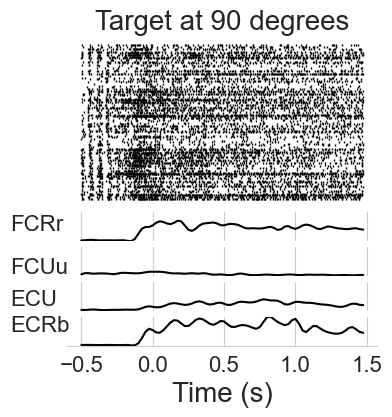

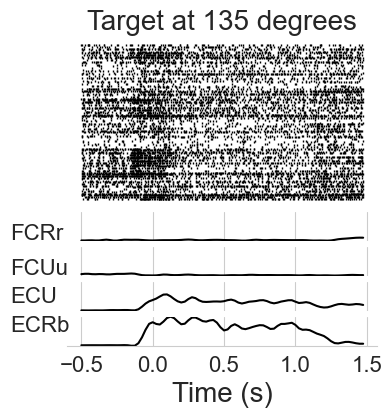

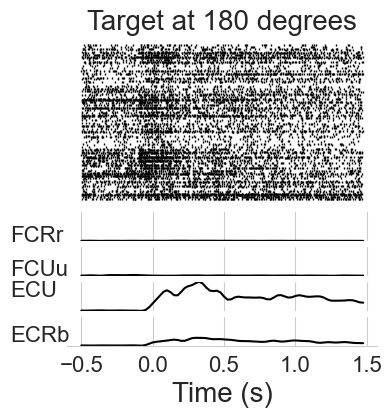

In [49]:
target_directions = [-135, -90, -45, 0, 45, 90, 135, 180] # A list for your interested target
bin_size = 0.025 # bin size
time_window = [-0.5, 1.5] # Seems to be the only option here
sample_idx = [] 

# Use the loop below to find the index of the first trial for each target
for each in target_directions:
    idx = np.where(np.array(jango['target direction']) == each)[0][0]
    sample_idx.append(idx)

# Plot 8 figures, each is for a single trial
for i, each in enumerate(sample_idx):
    fig = plt.figure('spike train and EMGs' + str(each), figsize = (4, 4))
    plot_spike_EMG(jango, each, ['EMG_FCRr', 'EMG_FCUu', 'EMG_ECU', 'EMG_ECRb'], offset = time_window[0], 
                   bin_size = bin_size, FR_flag = 0) # FR_flag is 0, to plot rasters

Now let's plot the firing rates with the EMGs.

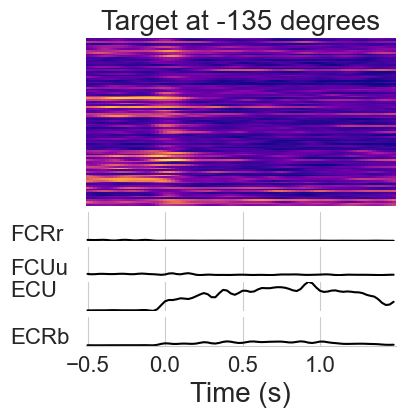

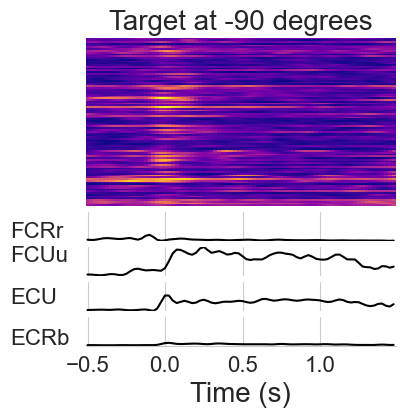

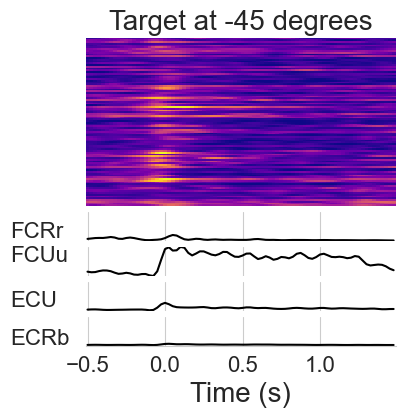

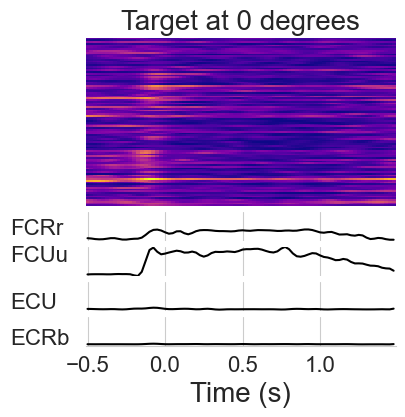

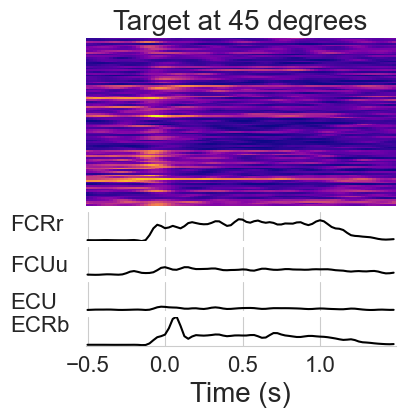

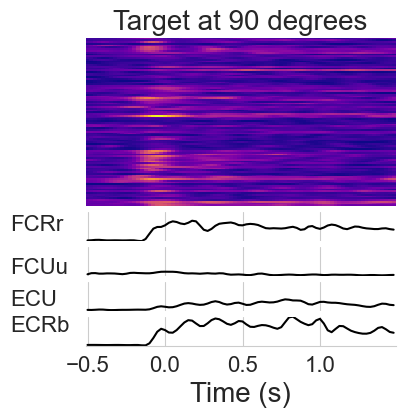

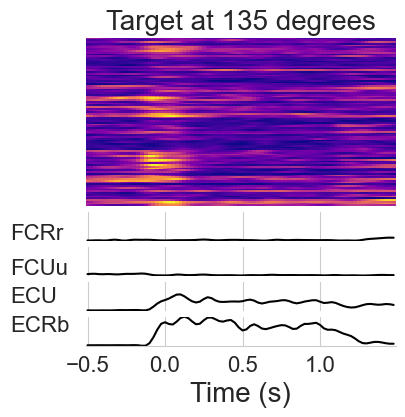

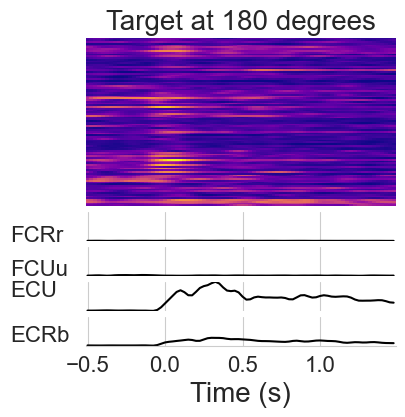

In [50]:
for i, each in enumerate(sample_idx):
    fig = plt.figure('spike train and EMGs' + str(each), figsize = (4, 4))
    plot_spike_EMG(jango, each, ['EMG_FCRr', 'EMG_FCUu', 'EMG_ECU', 'EMG_ECRb'], offset = time_window[0], 
                   bin_size = bin_size, FR_flag = 1) # Here the FR_flag is set as 1

<span style="color:red">**TO DO** </span>

* Call the function `plot_spike_EMG` like the examples above, but look at the activity of FDS, FDP and EDC

In [54]:
jango['muscle name']

['EMG_FCRr',
 'EMG_FCUu',
 'EMG_FDPr',
 'EMG_FDPu',
 'EMG_FDSu',
 'EMG_PL',
 'EMG_PT',
 'EMG_FDS',
 'EMG_ECU',
 'EMG_ECRb',
 'EMG_EDC1']

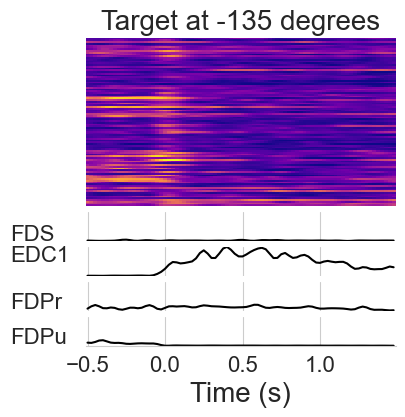

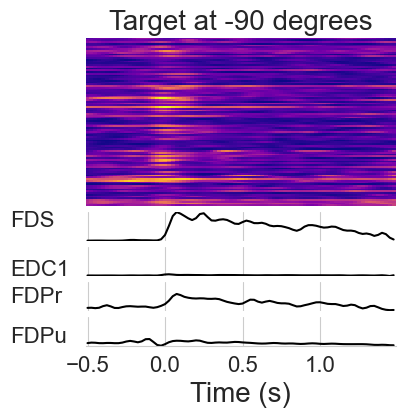

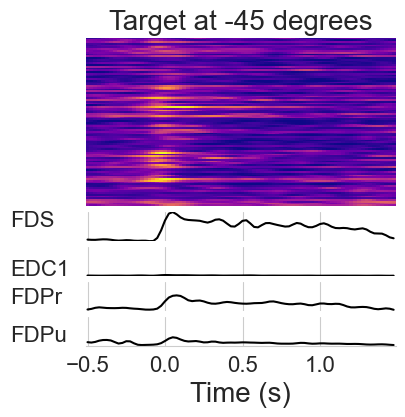

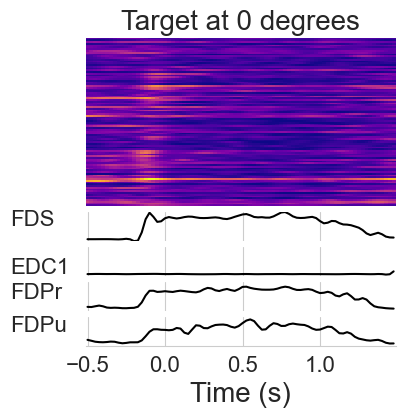

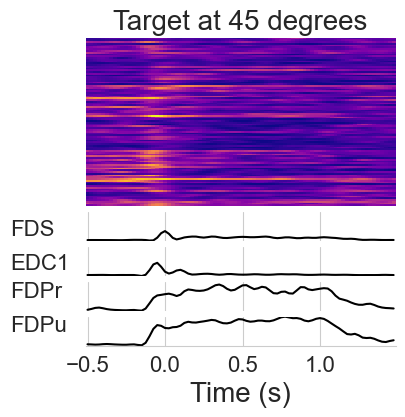

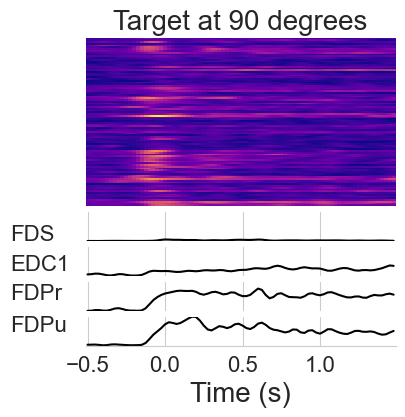

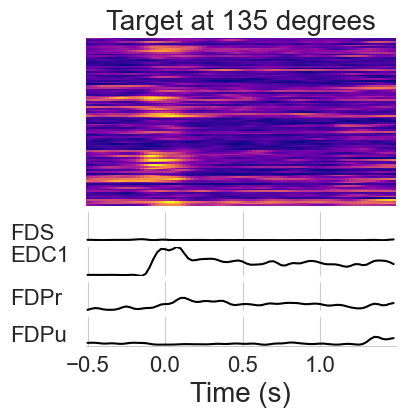

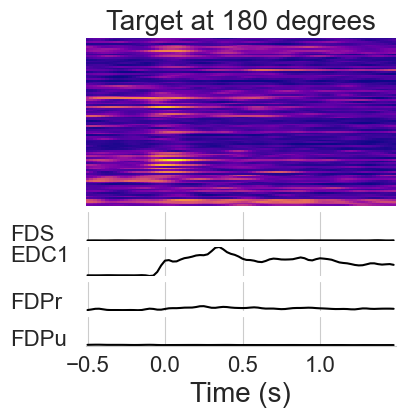

In [60]:
# ---- Your codes ---- #
for i, each in enumerate(sample_idx):
    fig = plt.figure('spike train and EMGs' + str(each), figsize = (4, 4))
    plot_spike_EMG(jango, each, ['EMG_FDS','EMG_EDC1','EMG_FDPr','EMG_FDPu'], offset = time_window[0],
                   bin_size = bin_size, FR_flag = 1) # Here the FR_flag is set as 1

## Exploring the latent space for M1 neural activity

Here we are going to use the neural firing rates within the first 300 trials to fit the PCA model, then visualize the data in the latent space, and evaluate how much variance are captured by the PCs. First, let's set the number of components as 10. And print out the explained variance ratio for the data to fit the PCA.

<span style="color:red">**TO DO** </span>

* Perform dimensionality reduction on M1 firing rates using PCA. You could call the [sklearn function](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* When fitting the PCA model, you may need to use np.concatenate to concatenate different trials
* Print out the explained variance ratio of each PC and also the cumsum.

In [77]:
# Pick some trials to fit the model, like the first 300 trials
# ---- Your codes ---- #
# jango['M1 firing rates'] --> 582 x 80 x 96, 
#          582 trials, 80 timesteps, 96 electrodes

# reshape the data 
# (we want the first 300 trials x 80 timesteps, for a single electrode)
data = np.zeros((300, 80))
electrode = 0
for trial in range(300):
    data[trial,:] = jango['M1 firing rates'][trial][:,electrode]
    
data.shape

(300, 80)

In [95]:
np.concatenate(jango['M1 firing rates'][:300]).shape

(24000, 96)

In [141]:
from sklearn.decomposition import PCA
# make a PCA model with S = 3
# this initializes the PCA object with 3 dimensions
pca = PCA(n_components=10)

# perform the dimensionality reduction
PCs = pca.fit_transform(np.concatenate(jango['M1 firing rates'][:300]))
pca.explained_variance_

array([15.46463254,  3.39971326,  2.47488819,  2.1238514 ,  1.09287021,
        0.80526073,  0.59578616,  0.53973031,  0.46961163,  0.44410239])

In [142]:
fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
# plot the x, y and z dimensions
#ax.scatter(PCs[:,0], PCs[:,1], PCs[:,2])
print(PCs.shape)
plt.scatter(PCs[:,0], PCs[:,1])
plt.show()

<IPython.core.display.Javascript object>

(24000, 10)


In [143]:
# this doesn't work for some weird reason...
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(PCs[:,0], PCs[:,1], PCs[:,2])
plt.show()

<IPython.core.display.Javascript object>

What if we want to know each of the PCs captures how much of the variance for a bunch of new data points? 

* Get the PC matrix $D$ by simply calling pca.components_ 
* Compute the covariance matrix $C$ of the data points
* Compute the explained variance ratio:
$$
explained\;variance\;ratio = \frac{diag(DCD^{T})}{trace(C)}
$$

<span style="color:red">**TO DO** </span>
* Follow the instructions above to write a function to compute the explained variance ratio by each PC for any given data.
* Use the function to get how much variance are captured by each PC for trials 300 ~ 400, and plot the results in any form you like.

[0.41220171 0.08764123 0.06792431 0.05747289 0.02717461 0.02143011
 0.01348674 0.01582375 0.01324921 0.01175021]
[0.41220171 0.49984294 0.56776725 0.62524013 0.65241474 0.67384485
 0.68733159 0.70315534 0.71640455 0.72815476]


Text(0.5, 0, 'PCs')

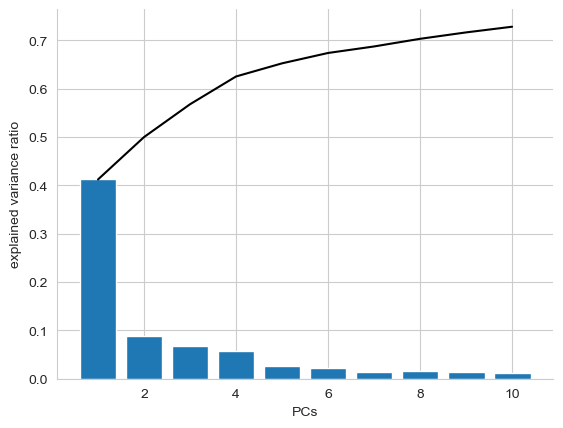

In [101]:
def my_explained_variance_ratio(pca, data):
    """
    Customer made function o compute the explained variance ratio
    Input
        pca: the fit PCA model, which is an instance of the class sklearn.decomposition.PCA
        data: new data samples, an ndarray, like np.concatenate(jango['M1 firing rates'][300:400])
    Return
        the explained variance ratio of each PC for the new data samples
    """
    # ---- Your code ---- #
    D = pca.components_
    C = np.cov(data.T)
    return np.diag(np.dot(np.dot(D, C), D.T))/sum(np.diag(C))
    
    

explained_variance_ratio = my_explained_variance_ratio(pca, np.concatenate(jango['M1 firing rates'][300:400]))
print(explained_variance_ratio)
cumsum_explained_variance_ratio = np.cumsum(explained_variance_ratio)
print(cumsum_explained_variance_ratio)

# ---- Plotting ---- #
plt.figure('explained variance ratio')
plt.bar(np.arange(len(explained_variance_ratio))+1, explained_variance_ratio)
plt.plot(np.arange(len(explained_variance_ratio))+1, cumsum_explained_variance_ratio, color = 'k')
sns.despine()
plt.ylabel('explained variance ratio')
plt.xlabel('PCs')

### Visualize the neural signals in the latent space

Here we are going to plot the neural signals projected in a 3-D space defined by the first 3 PCs.

In [102]:
from mpl_toolkits.mplot3d import Axes3D
target_directions = [-135, -90, -45, 0, 45, 90, 135, 180] # The 8 targets
color_list = plt.cm.jet(np.linspace(0, 1, 8)) # Each color is for a target, like color_list[4] for target at 45 degrees

<span style="color:red">**TO DO** </span>
* Call the `select_trials` function defined above to get a list of lists. Each list inside corresponds to a target.
* Finish the plotting, can be anything you like

In [103]:
# ---- Your codes ---- #
jango.keys()

dict_keys(['M1 firing rates', 'EMG', 'target direction', 'target corners', 'force', 'cursor position', 'cursor velocity', 'muscle name', 'M1 elec name', 'spike timing'])

In [126]:
trial_list = select_trials(jango, 'M1 firing rates', target_directions)
np.array(trial_list[1]).shape

(74, 80, 96)

Continue to finish the plotting.

In [139]:
%matplotlib notebook
fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
ax = Axes3D(fig)
for i, each in enumerate(trial_list):
    pca_trial = [pca.transform(each[j]) for j in range(len(each))] # Reuse the pca model fit above, only need to call the function transform
    #print(np.array(pca_trial).shape)
    # ---- Your codes ---- #
    # take the mean over the trials for the given angle
    mean_pca_trial = np.mean(pca_trial, axis = 0)
    # plot the first 3 principle components
    # the points are the time-in-trial, averaged over trials
    #plt.plot(mean_pca_trial[:, 0], mean_pca_trial[:, 1], mean_pca_trial[:, 2], color = color_list[i], linewidth = 2)
    ax.scatter(mean_pca_trial[:, 0], mean_pca_trial[:, 1], mean_pca_trial[:, 2], color = color_list[i])
    # plot the first 15 trials as well in a lighter color 
    #for single_trial in pca_trial[:15]:
    #    plt.plot(single_trial[:, 0], single_trial[:, 1], single_trial[:, 2], color = color_list[i], linewidth = 0.5, alpha = 0.5) 
plt.show()

<IPython.core.display.Javascript object>

### Add-on (optional)

You could try to fit a PCA model using only the trials from cardinal targets, and then test how much variance of the data from diagonal targets are captured by these PCs.

Same testing can also be done for the upper half targets and the lower half targets.
![targets split](../images/part_target_training.png)

## Build neural decoders for EMG prediction

### Build a Wiener filter based decoder

Here we use a Wiener filter to predict the EMGs from M1 neural activity. This type of decoder have been widely used in the past (Cherian, Krucoff, and Miller 2011; Naufel et al. 2019). The filter uses linear regression to predict the EMGs at time t with the given inputs stretching from present to T time bins in the past. We set T = 8 (200 ms) for the decoders here.

Specifically, a Wiener filter can be written in this form:
$$
\boldsymbol{y} (t)=\sum_{\tau=0}^{T-1}\boldsymbol{\beta}(\tau)\boldsymbol{x}(t-\tau)
$$

where $\boldsymbol{y}(t)$ is a q-dimensional vector ($q$ varied with the number of recorded EMGs) representing the EMGs to be predicted at time $t$, while $\boldsymbol{x}(t)$ is a $p$-dimensional vector for the inputs to the Wiener filter at time $t$ ($p=96$ in this case, which is the number of the electrodes in the cortical array), and $\boldsymbol{\beta}(\tau)$ is a $q\times p$ matrix corresponding to the filter parameters for time step $\tau$.

![wiener filter](../images/wiener_filter.png)

Of course, we can also write the equation for the Wiener filter in a matrix form:
$$
\boldsymbol{Y} = \boldsymbol{X}\boldsymbol{B}
$$

where $\boldsymbol{Y}$ is a $M\times q$ matrix for the EMGs to be predicted with $M$ being the number of samples, $\boldsymbol{X}$ is a $M\times (T\times p)$ matrix, and $\boldsymbol{B}$ is a $(T \times p)\times q$ matrix for the regression coefficients to be estimated.

Before the actual decoder training, we need to reshape the input data to match these requirements. Below is a toy example, where $T=4, p=4, q=2$, and 10 time steps are shown.

![wiener filter data format](../images/wiener_filter_format.png)

In this case, X will have $4\times4$ columns, and Y still has 2 columns. Since the first 3 time steps would be a blind zone for the Wiener filter, we should get $10-4+1$ training samples from the 10 time steps.

![wiener filter format 2](../images/wiener_filter_format_2.png)

In order to use the data from multiple trials as the training data, we will need to do this reshaping for each trial, and then concatenate them together.

<span style="color:red">**TO DO** </span>

* Write a function using the name `time_lag_reshape` to reshape the data within a single trial for Wiener filter fitting.
* Write another function using the name `time_lag_reshape_trials` to reshape the data for multiple trials and concatenate the reshaped data together. The outputs of this function should be two matrices, and will be used to fit parameters for the Wiener filter. You may need to call `time_lag_reshape`, the function above

In [144]:
def time_lag_reshape(x, y, n_lag):
    """
    To reshape the numpy arrays for Wiener filter fitting
    Parameters
        x: the input data for Wiener filter fitting, an ndarray
        y: the output data for Wiener filter fitting, an ndarray
        n_lag: the number of time lags, an int number
    Returns
        out1: the reshaped array for x, an ndarray
        out2: the trimmed array for y, an ndarray
    """
    # ---- Your codes ---- #
    # make a 2D array, with x.shape[0]-n_lag+1 rows of lagged values
    x_ = [x[i:i+n_lag, :].reshape(n_lag*x.shape[1]) for i in range(x.shape[0]-n_lag+1)]
    return np.asarray(x_), y[n_lag-1:, :]

def time_lag_reshape_trials(x, y, n_lag):
    """
    To reshape lists containing multiple trials into a big array so as to form 
    the training data for Wiener filter fitting
    Parameters
        x: a list containing multiple trials, as the inputs for Wiener filter fitting
        y: a list containing multiple trials, as the outputs for Wiener filter fitting
        n_lag: the number of time lags, an int number
    Returns
        out1: the reshaped data for the input list x, an ndarray
        out2: the reshaped data for the input list y, an ndarray
    """
    # ---- Your codes ---- #
    x_, y_ = [], []
    for each in zip(x, y):
        temp = time_lag_reshape(each[0], each[1], n_lag)
        x_.append(temp[0])
        y_.append(temp[1])
    # concatenate the Xs and Ys along the time axis
    return np.concatenate(x_), np.concatenate(y_)
    

Once the data is ready, the parameters of the Wiener filter could be determined by

$$
\boldsymbol{\hat{B}}=(\boldsymbol{X}^\mathsf{T}\boldsymbol{X})^{-1}\boldsymbol{X}^\mathsf{T}\boldsymbol{Y}
$$

In practice, We will need to add an additional bias term for both $\boldsymbol{X}$ and $\boldsymbol{B}$.

<span style="color:red">**TO DO** </span>

* Write a function to train the Wiener filter based on the equation above.
* Write a function to use the trained Wiener filter to do new predictions.

In [145]:
def train_wiener_filter(x, y):
    """
    To train a Wiener filter based decoder
    Input
        x: input data, an ndarray, should be the reshaped neural firing rates
        y: expected results, i.e. true EMG values
    Return
        H: a matrix for the decoder parameters
    """
    # ---- Your codes ---- #
    x_plus_bias = np.c_[np.ones((np.size(x, 0), 1)), x]
    return np.dot(np.dot(np.linalg.inv(np.dot(x_plus_bias.T, x_plus_bias)), x_plus_bias.T), y)
    
    
    
def test_wiener_filter(x, H):
    """
    Use a trained Wiener filter to predict the EMGs
    Input
        x: input data, an ndarray, should be the reshaped neural firing rates
        H: a matrix for the decoder parameters
    Return
        y: the predicted results
    """
    # ---- Your codes ---- #
    x_plus_bias = np.c_[np.ones((np.size(x, 0), 1)), x]
    return np.dot(x_plus_bias, H)
    
    

Once the functions are ready, we can do the actual decoder training and testing. Here let's use the first 300 trials to train the decoder, and use trials 300 ~ 400 to evaluate the performance of teh decoder.

In [146]:
# ---- Select the trials for training ---- #
x_train, y_train = jango['M1 firing rates'][:300], jango['EMG'][:300]

# ---- Format the data ---- #
x_train_, y_train_ = time_lag_reshape_trials(x_train, y_train, 8)
# ---- Call the training function defined above to train a decoder ---- #
H = train_wiener_filter(x_train_, y_train_)

# ---- Select the trials for testing ---- #
x_test, y_test = jango['M1 firing rates'][300:400], jango['EMG'][300:400]
# ---- Format the data ---- #
x_test_, y_test_ = time_lag_reshape_trials(x_test, y_test, 8)
# ---- Use the trained decoder to predict the EMGs ---- #
y_test_pred = test_wiener_filter(x_test_, H)
print('The shape of the parameter matrix is ' + str(H.shape)) # Think why

The shape of the parameter matrix is (769, 11)


To evaluate the decoder's performance, first we can plot both the predicted EMGs and the actual ones. See how well they match with each other.

In [147]:
def plot_predictions(fig_title, actual, predicted, plot_window, bin_size, EMG_names):
    """
    To plot the actual and predicted EMGs on top of each other
    Input
        fig_title: the title of your figure, a string
        actual: the actual EMG signals, an ndarray
        predicted: the predicted EMG signals, an ndarray
        plot_window: a list with two elements for the start and the end of the window you want to plot
        bin_size: the size of time bin, used to get the right x-axis ticks
        EMG_names: the names of the EMGs, a list of strings
    Return
        No return, but will produce a figure
    """
    fig = plt.figure(fig_title, figsize = (10, 10))
    N_channel = actual.shape[1]
    t = np.arange(plot_window[1] - plot_window[0])*bin_size
    for i in range(N_channel):
        ax = plt.subplot(N_channel, 1, i+1)
        l1, = plt.plot(t, actual[plot_window[0]:plot_window[1], i], color = 'k', linewidth = 1.5)
        l2, = plt.plot(t, predicted[plot_window[0]:plot_window[1], i], color = 'r', linewidth = 1)
        if i == N_channel - 1:
            plt.xlabel('Time (s)')
        if i == 0:
            ax.legend([l1, l2], ['Actual', 'Predicted'])
        plt.ylabel(EMG_names[i][4:])
        sns.despine()
        plt.tight_layout()
    

In [148]:
bin_size = 0.025
plot_predictions('real EMG vs predicted EMG using Wiener filter', y_test_, y_test_pred, [0, 500], bin_size, jango['muscle name'])

<IPython.core.display.Javascript object>

### Evaluate the performance of the EMG decoder

To evaluate the goodness of fit for the EMGs on a specific muscle, we could use the coefficient of determination, namely, the $R^{2}$, which is defined below:

$$
R^{2}(y, \hat{y}) = 1-\frac{\sum_{i=1}^{N}(\hat{y}_{i}-y_{i})^2}{\sum_{i=1}^{N}(y_{i}-\bar{y}_{i})^2}
$$

Here $N$ represents the total number of samples used to compute the $R^2$ value, and both $y$ and $\hat{y}$ are for one single muscle. If there are 11 muscles, then we will have 11 $R^2$ values for all the muscles.

What if we want to use a single number to quantify the prediction accuracy of the decoder? To do this, we can use a multi-variate $R^2$ defined as below:

$$
mR^{2}(y, \hat{y}) = 1-\frac{\sum_{m=1}^{M}\sum_{i=1}^{N}(\hat{y}_{i,m}-y_{i,m})^2}{\sum_{m=1}^{M}\sum_{i=1}^{N}(y_{i,m}-\bar{y}_{i,m})^2}
$$

Here M represents the number of muscles. This equation can also be written as

$$
mR^{2}(y, \hat{y}) =1-\frac{\sum_{m=1}^{M}SS_{res, m}}{\sum_{m=1}^{M}SS_{tot, m}}
$$

where $SS_{res}$ is the residual sum of squares and $SS_{tot}$ is the total sum of squares. Further, it can be written as

$$
mR^{2}(y, \hat{y}) =\sum_{m=1}^{M}p_{m}R^{2}_{m}
$$

where $p_{m}=\frac{SS_{tot,m}}{\sum_{m=1}^{M}SS_{tot,m}}$. So the $mR^{2}$ can be viewed as the variance weighted sum of single-channel $R^{2}$s.

For single-channel $R^2$, we can use `sklearn.metrics.r2_score` to compute by calling `r2 = r2_score(y, y^hat, multioutput='raw_values')`.

For multi-variate $R^2$, we can compute by calling `r2 = r2_score(y, y^hat, multioutput='variance_weighted')`. 

In [149]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_, y_test_pred, multioutput='raw_values')
m_r2 = r2_score(y_test_, y_test_pred, multioutput='variance_weighted')

print('EMG decoding accuracy for Wiener filter. \n')
print('The R^2 for each muscle:')
for i in range(len(r2)):
    print('%s: %.3f'%(jango['muscle name'][i][4:], r2[i]))
print('\nThe multi-variate R^2 is: %.3f'%(m_r2))

EMG decoding accuracy for Wiener filter. 

The R^2 for each muscle:
FCRr: 0.753
FCUu: 0.739
FDPr: 0.783
FDPu: 0.780
FDSu: 0.744
PL: 0.647
PT: 0.744
FDS: 0.739
ECU: 0.750
ECRb: 0.856
EDC1: 0.796

The multi-variate R^2 is: 0.754


### Add a static nonlinearity after the Wiener filter ---- Wiener cascade model

Wiener cascade consists of a dynamic linear stage followed by a fixed static nonlinearity. There are different options for the nonlinearity. Here we could explore a polynomial nonlinearity and a sigmoid nonlinearity.

During decoder training, the linear part will be fit first. Then the outputs of the linear part are passed to the nonlinear function to determine its parameters. We could call `sklearn.optimize.least_squares` to finish this step.
![wiener cascade](../images/wiener_cascade.png)

In [150]:
from scipy.optimize import least_squares

def nonlinearity(p, x, nonlinear_type):
    """
    A function defining the nonlinear function
    Input
        p: the parameters for the nonlinearity
        x: the inputs to the nonlinearity
        nonlinear_type: the type of the nonlinearity, there are two options 'poly' and 'sigmoid'
    Returns
        A nonlinear function handle
    """
    if nonlinear_type == 'poly': # polynomial nonlinearity
        return p[0]+p[1]*x+p[2]*x*x
    elif nonlinear_type == 'sigmoid': # sigmoid nonlinearity
        return 1/( 1+np.exp(-8*(x-p[0])) )
    
def nonlinearity_residue(p, x, z, nonlinear_type):
    """
    A function that will be sent to scipy.optimize.least_squares
    """
    return (nonlinearity(p, x, nonlinear_type) - z).reshape((-1,))

def train_nonlinear_wiener_filter(x, y, nonlinear_type):
    """
    Input
        x: input data, an ndarray, should be the reshaped neural firing rates
        y: expected results, i.e. true EMG values
        nonlinear_type: the type of the nonlinearity, there are two options 'poly' and 'sigmoid'
    Returns
        out1: the parameter matrix H for the linear part
        out2: the nonlinear function NL with optimized parameters
    """
    x_plus_bias = np.c_[np.ones((np.size(x, 0), 1)), x]
    temp = np.linalg.inv(np.dot(x_plus_bias.T, x_plus_bias))
    temp2 = np.dot(temp,x_plus_bias.T)
    H = np.dot(temp2,y)
    y_pred = test_wiener_filter(x, H)
    if nonlinear_type == 'poly':
        init = [0.1, 0.1, 0.1]
    elif nonlinear_type == 'sigmoid':
        init = [0.5]
    # ---- 
    NL = least_squares(nonlinearity_residue, init, args = (y_pred, y, nonlinear_type))  
    return H, NL
    
def test_nonlinear_wiener_filter(x, H, NL, nonlinear_type):  
    """
    To get predictions from input data x with nonlinear decoder
    x: input data
    H: parameter matrix obtained by the training function
    NL: nonlinear components obtained by the training function
    """
    y1 = test_wiener_filter(x, H)
    y2 = nonlinearity(NL.x, y1, nonlinear_type)
    return y2    

Similar codes as a cell above, but use `train_nonlinear_wienner_filter` and `test_nonlinear_wiener_filter` instead.

<span style="color:red">**TO DO** </span>
* Write your own codes to call `train_nonlinear_wienner_filter` and `test_nonlinear_wiener_filter` functions for nonlinear decoder training.

In [157]:
# ---- Your codes ---- #
# ---- Select the trials for training ---- #
x_train, y_train = jango['M1 firing rates'][:300], jango['EMG'][:300]

# ---- Format the data ---- #
x_train_, y_train_ = time_lag_reshape_trials(x_train, y_train, 8)
# ---- Call the training function defined above to train a decoder ---- #
H, NL = train_nonlinear_wiener_filter(x_train_, y_train_, 'sigmoid')

# ---- Select the trials for testing ---- #
x_test, y_test = jango['M1 firing rates'][300:400], jango['EMG'][300:400]
# ---- Format the data ---- #
x_test_, y_test_ = time_lag_reshape_trials(x_test, y_test, 8)
# ---- Use the trained decoder to predict the EMGs ---- #
y_test_pred = test_nonlinear_wiener_filter(x_test_, H, NL, 'sigmoid')
print('The shape of the parameter matrix is ' + str(H.shape)) # Think why

y_test_, y_test_pred

The shape of the parameter matrix is (769, 11)


(array([[0.03669079, 0.04180043, 0.15309104, ..., 0.02429962, 0.00915866,
         0.01648715],
        [0.0096744 , 0.02785339, 0.16297628, ..., 0.04244798, 0.02787513,
         0.0948361 ],
        [0.00133499, 0.00606804, 0.11372759, ..., 0.05543924, 0.04392987,
         0.23066301],
        ...,
        [0.68426809, 0.40991965, 0.76730472, ..., 0.02322087, 0.28567517,
         0.0146666 ],
        [0.56475815, 0.39473377, 0.68032703, ..., 0.02463709, 0.26876553,
         0.01158218],
        [0.41816215, 0.36691822, 0.51987052, ..., 0.0306006 , 0.25776936,
         0.01203925]]),
 array([[0.03741195, 0.08686074, 0.10012511, ..., 0.03385179, 0.03438694,
         0.0115128 ],
        [0.02505866, 0.05119758, 0.05805245, ..., 0.02387946, 0.03213168,
         0.00858129],
        [0.0254084 , 0.0425658 , 0.05758827, ..., 0.03021761, 0.042389  ,
         0.01554645],
        ...,
        [0.4260514 , 0.12572808, 0.40384819, ..., 0.02856835, 0.07941524,
         0.01445452],
        [0.4

In [155]:
bin_size = 0.025
plot_predictions('real EMG vs predicted EMG using Wiener filter', y_test_, y_test_pred, [0, 500], bin_size, jango['muscle name'])

Performance evaluation.

In [159]:
from sklearn.metrics import r2_score
# ---- Your codes ----  #

r2 = r2_score(y_test_, y_test_pred, multioutput='raw_values')
m_r2 = r2_score(y_test_, y_test_pred, multioutput='variance_weighted')

#---------------------------------------------------#
print('EMG decoding accuracy for Wiener cascade. \n')
print('The R^2 for each muscle:')
for i in range(len(r2)):
    print('%s: %.3f'%(jango['muscle name'][i][4:], r2[i]))
print('\nThe multi-variate R^2 is: %.3f'%(m_r2))

EMG decoding accuracy for Wiener cascade. 

The R^2 for each muscle:
FCRr: 0.798
FCUu: 0.782
FDPr: 0.777
FDPu: 0.809
FDSu: 0.768
PL: 0.637
PT: 0.776
FDS: 0.792
ECU: 0.675
ECRb: 0.838
EDC1: 0.698

The multi-variate R^2 is: 0.751


### Neural networks based decoder ---- coding with pyTorch

Here we will implement a neural network based decoder to transform the neural firing rates as well as the history in the past several time steps into EMGs. Of course this can be done with a more sophisticated recurrent neural network (RNN). However, we keep things simple here, we will use a feedforward neural network, and simply stack the historic time steps together, use the data reshaped by `time_lag_reshape_trials` (exactly the same to the Wiener filter) as the inputs to the neural network. The outcome may still be good.

First, import necessary packages.

In [168]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
from datetime import datetime
import pickle

device = torch.device('mps')

Now define a class for the decoder and also the functions for training and testing. You will be provided most of the codes. You will play with a few hyperparameters, and let's see **who can get the highest $mR^{2}$ value**.

The hyper-parameters you can tune include:
* The activation function in each hidden layer.
* The type of loss function
* The type of the optimizer
* decoder_params['hidden_dim']
* training_params['epochs']
* training_params['batch_size']
* training_params['lr']
* training_params['drop_out']

In [179]:
# ---- A class to convert the ordinary data into pytorch dataset ---- #
class dataformat_xy(Dataset):# inherited from Dataset
    def __init__(self, x, y):
        self.x = x # typically to be the reshaped neural firing rates
        self.y = y # typically to be the EMGs

    def __getitem__(self, item):
        x_t = self.x[item]
        y_t = self.y[item]
        return x_t, y_t

    def __len__(self):
        return len(self.x)

class nn_decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, 
                 drop_out = 0.1):
        """
        input_dim: The number of dimensions of the inputs
        hidden_dim: The number of dimensions of the hidden layer
        output_dim: The number of dimensions of the output layer
        drop_out: The ratio of drop-out
        """
        super(nn_decoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.drop_out = drop_out
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.Dropout(self.drop_out), 
            nn.ReLU(),# ******** Could change the type of nonlinearity here ********, nn.ELU, nn.Softplus, nn_ReLU
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Dropout(self.drop_out), 
            nn.ReLU(),# ******** Could change the type of nonlinearity here ********, nn.ELU, nn.Softplus, nn_ReLU
            nn.Linear(self.hidden_dim, self.output_dim),
        )

    def forward(self, input):
        x = self.model(input)
        return x
    
def train_nn_decoder(x, y, decoder_params, training_params):
    """
    training function for nn_decoder
    """
    # ----------- Taking care of GPU --------------
    use_cuda = 0
    if torch.cuda.is_available():
        use_cuda = 1
    # ----------- Specifying hyper-parameters -------------
    hidden_dim = decoder_params['hidden_dim']
    epochs = training_params['epochs']
    batch_size = training_params['batch_size']
    lr = training_params['lr']
    drop_out = training_params['drop_out']
    # ----------- Training logs --------- #
    train_log = {'iter':[], 'epoch':[], 'loss_decoder':[], 'batch_idx': []}
    # ----------- Getting instances --------------------- #
    decoder = nn_decoder(x.shape[1], hidden_dim, y.shape[1], drop_out)
    decoder.to(device)
    
    if use_cuda == 1:
        decoder = decoder.cuda()

    # ------------ Specifying the loss --------------- #
    # ************** Could change the type of loss here *************** #
    criterion_decoder = torch.nn.MSELoss()  # could try L1 loss? torch.nn.L1Loss()
    # ********************************************************************** #
    
    # ------------ Specifying the optimizer --------------- #
    # ************** Could change the type of optimizer here *************** #
    decoder_optim = optim.Adam(decoder.parameters(), lr = lr) # Adam is the widely used, could try SGD or RMSprop
    # ********************************************************************** #
    
    loader = DataLoader(dataset = dataformat_xy(x, y),
                        batch_size = batch_size,
                        shuffle = True)
    decoder.train()
        
    for epoch in tqdm.notebook.tqdm(range(epochs)):
        for batch_idx, (x_, y_) in enumerate(loader):
            x_, y_ = x_.type('torch.FloatTensor'), y_.type('torch.FloatTensor')
            if use_cuda == 1:
                x_ = x_.cuda()
                y_ = y_.cuda()
            
            x_ = x_.to(device)
            y_ = y_.to(device)
            
            decoder_optim.zero_grad()
            pred = decoder.forward(x_)
            loss_decoder = criterion_decoder(pred, y_)
            
            loss_decoder.backward()
            decoder_optim.step()
            train_log['epoch'].append(epoch)
            train_log['batch_idx'].append(batch_idx)
            train_log['loss_decoder'].append(loss_decoder.item())
        if epoch%50 == 0:
            print('epoch %d: loss is %.3f'%(epoch, loss_decoder.item()))
    # ---- save the training log ---- #
    dt_string = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    with open('./training_logs/train_log_' + dt_string + '.pkl', 'wb') as fp:
        pickle.dump(train_log, fp)        
    return decoder
        
def test_nn_decoder(decoder, test_x, use_cuda=False):
    """
    Use a trained decoder to predict the outputs
    """
    decoder = decoder.eval()
    with torch.no_grad():
        test_x = torch.from_numpy(test_x).type('torch.FloatTensor')
        test_x = test_x.to(device)
        if use_cuda:
            test_x = test_x.cuda()
        pred = decoder(test_x)
        pred = pred.to(device)
        if use_cuda:
            pred = pred.cpu()
    return pred.data.cpu().numpy()    

Decoder training.

<span style="color:red">**TO DO** </span>
* Tune the hyperparameters to get as high as $mR^{2}$
* Can change both the HPs below and the codes above
* Try some wild values to see what will happen, like very large learning rate (0.05, 0.1) or very large batch size (1024)

In [177]:
import torch

decoder_params, training_params = {}, {}
decoder_params['hidden_dim']=256
training_params['epochs'] = 100
training_params['batch_size'] = 128
training_params['lr'] = 0.001
training_params['drop_out'] = 0.05

x_train, y_train = jango['M1 firing rates'][:300], jango['EMG'][:300]
x_train_, y_train_ = time_lag_reshape_trials(x_train, y_train, 8)

x_test, y_test = jango['M1 firing rates'][300:400], jango['EMG'][300:400]
x_test_, y_test_ = time_lag_reshape_trials(x_test, y_test, 8)

# ---- decoder training ---- #
decoder = train_nn_decoder(x_train_, y_train_, decoder_params, training_params)

decoder.to(device)

# ---- Save the trained model ---- #
torch.save(decoder, './' + 'nn_decoder' + '.pth')
# ---- Use the trained decoder to predict EMGs ---- #

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0: loss is 0.035
epoch 50: loss is 0.007


AssertionError: Torch not compiled with CUDA enabled

In [181]:
y_test_pred = test_nn_decoder(decoder, x_test_, False)
y_test_pred

array([[0.05212333, 0.1321773 , 0.08217276, ..., 0.03948765, 0.01611795,
        0.03125531],
       [0.03173605, 0.0870911 , 0.04859482, ..., 0.01119727, 0.00328958,
        0.01943947],
       [0.02570078, 0.07172853, 0.04758771, ..., 0.01763223, 0.01697936,
        0.04343363],
       ...,
       [0.37438768, 0.24851745, 0.4691695 , ..., 0.08827287, 0.16801807,
        0.07848538],
       [0.32184622, 0.23680268, 0.39281607, ..., 0.08097173, 0.15321061,
        0.07154826],
       [0.28695565, 0.23247892, 0.35064194, ..., 0.07777983, 0.15015641,
        0.07152138]], dtype=float32)

In [182]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_, y_test_pred, multioutput='raw_values')
m_r2 = r2_score(y_test_, y_test_pred, multioutput='variance_weighted')

print('EMG decoding accuracy for neural network based decoder. \n')
print('The R^2 for each muscle:')
for i in range(len(r2)):
    print('%s: %.3f'%(jango['muscle name'][i][4:], r2[i]))
print('\nThe multi-variate R^2 is: %.3f'%(m_r2))

EMG decoding accuracy for neural network based decoder. 

The R^2 for each muscle:
FCRr: 0.860
FCUu: 0.836
FDPr: 0.833
FDPu: 0.885
FDSu: 0.797
PL: 0.834
PT: 0.861
FDS: 0.816
ECU: 0.859
ECRb: 0.896
EDC1: 0.889

The multi-variate R^2 is: 0.851


Plot the training logs.

In [183]:
with open('./training_logs/train_log_06_07_2022_16_38_31.pkl', 'rb') as fp:
    train_log = pickle.load(fp)
plt.figure('Training history')
ax = plt.subplot(111)
plt.plot(train_log['loss_decoder'])
plt.xlabel('iterations')
plt.ylabel('loss')
ax.set_xscale('log')

<IPython.core.display.Javascript object>

Plot the predicted EMGs obtrained from neural network decoder. Compare to the one obtained by Wiener filter.

In [184]:
bin_size = 0.025
plot_predictions('real EMG vs predicted EMG using nn decoder', y_test_, y_test_pred, [0, 500], bin_size, jango['muscle name'])

<IPython.core.display.Javascript object>

## Decoding EMGs from latent signals

Here we want to compare two scenarios for the EMG decoding problem: decoding EMGs directly from the full-dimensional neural recordings, and decoding EMGs from the latent signals. For the latter one, we will need to perform a dimensionality reduction procedure prior to decoder building. Here we will use PCA as the dimensionality reduction method. In later courses, you will have opportunities to do the same thing but with other DR methods. 

<span style="color:red">**TO DO** </span>

* Will dimensionality reduction bring the loss of information? How could it influence the EMG decoding accuracy?

* To decode EMGs from latent signals obtained by PCA, generate a graph showing how decoding accuracy change with the number of dimensions.

* Use only training data to estimate the PCA model.

* At the same time, build decoders to predict EMGs from full-D neural firing rates, and compare with the above one.

* Let's do 5-fold cross-validation may be needed to draw a conclusion.

![guess](../images/guess.jpg)

Coding in functions so the program will be more concise. You may need to call the functions defined previously for Wiener filter training.

In [186]:
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

def train_decoder_from_latent(x, y, n_lags, n_dimension):
    """
    Input
        x: a list containing the M1 neural firing rates from training trials
        y: a list containing the EMGs from training trials
        n_lags: the time lag for the Wiener filter
        n_dimension: the dimensions of the latent space
    Return
        out1: the decoder matrix H
        out2: the PCA model
    """
    # ---- Your codes ---- #
    # do PCA
    pca_model = PCA(n_components=n_dimension)
    pca_model.fit_transform(np.concatenate(x, axis=0))
    pca_x = [pca.transform(each) for each in x]
    
    # train Wiener filter
    # ---- Format the data ---- #
    x_train_, y_train_ = time_lag_reshape_trials(pca_x, y_train, 8)
    # Call the training function defined above to train a decoder
    H = train_wiener_filter(x_train_, y_train_)
    return H, pca_model


def test_decoder_from_latent(x, y, H, pca, n_lags):
    """
    Input
        x: a list containing the M1 neural firing rates from training trials
        y: a list containing the EMGs from training trials
        H: a trained decoder
        pca: a fit PCA model
        n_lags: number of time lags
    Return
        out1: a single number for the mR^2
    """
    # ---- Your codes ---- #
    pca_x = [pca.transform(each) for each in x]
    x_test_, y_test_ = time_lag_reshape_trials(pca_x, y, n_lags)
    y_test_pred = test_wiener_filter(x_test_, H)
    r2 = r2_score(y_test_, y_test_pred, multioutput = 'variance_weighted')
    return r2
    
    

Now call the functions defined above to test a number of dimensionalities.

In [188]:
from sklearn.model_selection import KFold
from IPython.display import clear_output
n_lags = 8

x, y = jango['M1 firing rates'][:400], jango['EMG'][:400] # 400 trials, you will need to do 5-fold cross-validation on it
D = np.arange(2, 34, 2) # probably can test higher
# ---- Your codes ---- #


r2s = []
for num_latents in range(10):
    H, pca = train_decoder_from_latent(x, y, n_lags=10, n_dimension=num_latents)
    r2s.append(test_decoder_from_latent(x, y, H, pca, n_lags=num_latents))
    
    
plt.figure()
plt.plot(num_latents, r2s)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [400, 32400]

Now build decoders from full-D neural recordings to EMGs.

In [ ]:
n_lags = 8
# ---- Put a group of good parameters for the nn decoder here ---- #
decoder_params, training_params = {}, {}
decoder_params['hidden_dim']=256
training_params['epochs'] = 100
training_params['batch_size'] = 128
training_params['lr'] = 0.001
training_params['drop_out'] = 0.05

x, y = jango['M1 firing rates'][:400], jango['EMG'][:400] # 400 trials, you will need to do 5-fold cross-validation on it

r2_full_wiener = []
r2_full_nn = []
kf = KFold( n_splits = 5, shuffle = False )
for train_idx, test_idx in kf.split(x):
    # ---- split data into train and test ---- #
    # ---- Your codes ---- #
    
    
    
    
    
    
    
    
    
    

Plot the results.

In [ ]:
r2_pca_mean = [np.mean(each) for each in r2_all_pca]
r2_pca_std = [np.std(each) for each in r2_all_pca]

plt.figure('decoding from PCA space', figsize = (12,6))

l1 = plt.errorbar(D, r2_pca_mean, yerr=r2_pca_std, fmt='o-', color='darkred', capsize=3, zorder = 10)
l2 = plt.axhline(np.mean(r2_full_wiener), linestyle = '--', color = 'darkred')
l3 = plt.axhline(np.mean(r2_full_nn), linestyle = '--', color = 'orange')
plt.ylim([0.25, 0.9])
sns.despine()
plt.tight_layout()
plt.xlabel('Dimensionality', fontsize = 26)
plt.ylabel('R^2', fontsize = 26)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.grid()
plt.legend([l1, l2, l3], 
           ['Wiener filter from latent signals', 'Wiener filter from full-D neural signals', 'NN from full-D neural signals'], 
           prop = {'size': 20})